<a href="https://colab.research.google.com/github/EdwardMMiller/Data-Mining-Project---Fall-2022/blob/main/News_Classifier_COLAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NEWS CLASSIFIER**

## DATA MINING - FALL 2022
## CUNY GRADUATE CENTER
## Edward Miller

## Overview

Over the past few decades, news sources have drastically shifted from print media to
online sites due to the widespread adoption of the internet by the general public. As a
consequence of this shift, it has become easier for news articles from untrustworthy
sources to pass themselves as real, and cause disinformation to spread rapidly. This
disinformation can cause widespread damage and is often used to push false narratives to
benefit a political party or a government. It has already caused harm to democratic
institutions by eroding trust in media sources, as well as motivating extreme actions based
on incorrect information, such as the Capitol Riots on January 6, 2021 . Therefore, it is now
more important than ever to develop sound methods for determining whether a news
story is real, or not. The intent of this project will be to use deep learning in order to train a
model that can correctly classify a list of news stories as real or not real.

## Goals
1. Train a deep learning model for binary classification to correctly classify whether a
news story is real
2. Test Trained Model on a dataset to determine how well it differentiates between the
two classes, and report findings.

## Dataset
The dataset, as well as the direct inspiration for this project, comes from the following kaggle
website, and the author of the code has some good insights that will be reused here as well.

https://www.kaggle.com/code/urkchar/determine-if-news-is-fake-or-real/notebook

Progress will be updated through Github here:

https://github.com/EdwardMMiller/Data-Mining-Project---Fall-2022/new/main

In [1]:
!pip install pandas
!pip install numpy
!pip install tensorflow==2.9.2'
!pip install keras
!pip3 install seaborn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/bin/bash: -c: line 0: unexpected EOF while looking for matching `''
/bin/bash: -c: line 1: syntax error: unexpected end of file
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from absl import logging
import tensorflow as tf
import tensorflow_hub as hub
import keras as K
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, train_test_split
import re
import zipfile
# library imports

In [3]:
URL_T = 'https://raw.githubusercontent.com/EdwardMMiller/Data-Mining-Project---Fall-2022/main/True.csv'
URL_F = "https://raw.githubusercontent.com/EdwardMMiller/Data-Mining-Project---Fall-2022/main/Fake.csv"
# getting data from Github

True_df = pd.read_csv(URL_T)
Fake_df = pd.read_csv(URL_F)
# getting the csv files into dataframe

print("Number of rows in True_df = ", True_df.shape[0])
print("Number of rows in Fake_df = ", Fake_df.shape[0])
print("Number of columns in True_df = ", True_df.shape[1])
print("Number of columns in Fake_df = ", Fake_df.shape[1])
# Checking number of rows and columns in each dataset

columns_list_T = True_df.columns.tolist()
columns_list_F = Fake_df.columns.tolist()
print("List of columns in True_df", columns_list_T)
print("List of columns in False_df", columns_list_T)
# checking to see if columns are the same
#%%
def data_file_explore(file, df):

  """
    This is a simple function designed to do surface level
    exploration of the data in a csv file. It will print the
    first five rows of a data file, number of rows and columns in the data file
    number of unique values in the data value, and the number of missing values
    in the data file. It also inputs the minimum, maximum, mean and median
    for the numeric columns, and then finds the mode for the column along with
    the number of times it appears in that column. Finally, it also gets the
    most frequent string found for the string columns along with the number of
    times that string is found in the column. It is assumed that the data
    that is being worked with is either numeric or a string.

  Args:
    file = string referencing the filename
    df = a data frame created from reading in the file
  Returns:
    none
  """
  
  print("*********************** FILE NAME: %s ***********************\n" %file)

  # This is just a file header

  print("First five rows in file: %s\n" %file)
  display(df.head())
  # looking at the first five rows of the data

  print("\nData types present in file: %s\n" %file)
  print(df.dtypes)
  # looking at data types found in the dataframe

  print("\nNumber of rows and columns in file: %s\n" %file)
  display(df.shape)
  # Getting the size of the dataset

  print("\nNumber of unique values for each column in file: %s\n" %file)
  display(df.nunique())
  # Looking at number of unique values

  print("\nCount of missing values in file: %s\n" %file)
  display(df.isnull().sum())
  print("")
  # Counting the missing values in the datasets

  for col in df.select_dtypes(include=np.number):
    # Looping through numeric columns in data frame a
      #print("Min for col %s = %s" %(col, df[col].min()))
      #print("Max for col %s = %s" %(col, df[col].max()))
    print("Numerical Stats for column - '%s' " % col)
    print("--------------------------------------------")
    (print("Min: %s Mean: %s"
           %(df[col].min(), df[col].mean() )))
    print("Max: %s Median: %s" %(df[col].max(), df[col].median()))
    # Printing the minimum, maximum, mean and median

    col_mode = df[col].value_counts().idxmax()
    # get the most frequent value in the column
    freq = df[col].value_counts()[col_mode]
    # get the count of the most frequent value in the column

    if freq > 1:
      print("Most frequent value: %s found in column %s times.\n" %(col_mode,freq))
    else:
      print("No value repetitions found in column\n")
      # Only returning the most frequent value if it appears more than once

  for col in df.select_dtypes(include=object):
      # Only looking at columns with strings now
    print("Frequency counts for string column - '%s' " % col)
    print("--------------------------------------------------")
    col_mode = df[col].value_counts().idxmax()
      # get the most frequent value in the column
    freq = df[col].value_counts()[col_mode]
      # get the count of the most frequent value in the column
    if freq > 1:
      (print("Most frequent string value: '%s' found in column %s times.\n"
               %(col_mode,freq)))
    else:
      print("No value repetitions found in column\n")
        # Only returning the most frequent value if it appears more than once

data_file_explore('True.csv', True_df)
data_file_explore('Fake.csv', Fake_df)


Number of rows in True_df =  21417
Number of rows in Fake_df =  23481
Number of columns in True_df =  4
Number of columns in Fake_df =  4
List of columns in True_df ['title', 'text', 'subject', 'date']
List of columns in False_df ['title', 'text', 'subject', 'date']
*********************** FILE NAME: True.csv ***********************

First five rows in file: True.csv



,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"



Data types present in file: True.csv

title      object
text       object
subject    object
date       object
dtype: object

Number of rows and columns in file: True.csv



(21417, 4)


Number of unique values for each column in file: True.csv



title      20826
text       21192
subject        2
date         716
dtype: int64


Count of missing values in file: True.csv



title      0
text       0
subject    0
date       0
dtype: int64


Frequency counts for string column - 'title' 
--------------------------------------------------
Most frequent string value: 'Factbox: Trump fills top jobs for his administration' found in column 14 times.

Frequency counts for string column - 'text' 
--------------------------------------------------
Most frequent string value: '(Reuters) - Highlights for U.S. President Donald Trump’s administration on Thursday: The United States drops a massive GBU-43 bomb, the largest non-nuclear bomb it has ever used in combat, in Afghanistan against a series of caves used by Islamic State militants, the Pentagon says. Trump says Pyongyang is a problem that “will be taken care of” amid speculation that North Korea is on the verge of a sixth nuclear test. Military force cannot resolve tension over North Korea, China warns, while an influential Chinese newspaper urges Pyongyang to halt its nuclear program in exchange for Beijing’s protection. The Trump administration is focusing its North Korea stra

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"



Data types present in file: Fake.csv

title      object
text       object
subject    object
date       object
dtype: object

Number of rows and columns in file: Fake.csv



(23481, 4)


Number of unique values for each column in file: Fake.csv



title      17903
text       17455
subject        6
date        1681
dtype: int64


Count of missing values in file: Fake.csv



title      0
text       0
subject    0
date       0
dtype: int64


Frequency counts for string column - 'title' 
--------------------------------------------------
Most frequent string value: 'MEDIA IGNORES Time That Bill Clinton FIRED His FBI Director On Day Before Vince Foster Was Found Dead' found in column 6 times.

Frequency counts for string column - 'text' 
--------------------------------------------------
Most frequent string value: ' ' found in column 626 times.

Frequency counts for string column - 'subject' 
--------------------------------------------------
Most frequent string value: 'News' found in column 9050 times.

Frequency counts for string column - 'date' 
--------------------------------------------------
Most frequent string value: 'May 10, 2017' found in column 46 times.



## OVERVIEW OF DATA SETS

A cursory glance at the data shows that there are no missing values in either data set and that both column types
are the same along with matching data types. There are no numerical columns her, only text and dates. However, the author of the original project points out that the **True.csv** file  shows **WASHINGTON (Reuters) - ** or **SEATTLE/WASHINGTON (Reuters)** before the news articles. Also, there are **6** unique values for **'subject'** in the **Fake.csv** file and only **2** unique values for **'subject'** in the **True.csv**, which might cause the model while training the dataset to mainly look for these two things to determine whether the news article is fake. We will want to remove these things in order to ensure that it's not so obvious which one is which, and also ensure that the model will be able to work when classifying news stories that do not have this format, as one could then easily add the <Reuters> term to a fake news story, in order to trick the model into classifying it is as true.

In [4]:
cnt = 0
for row in True_df.index:
  if "(Reuters)" in True_df.loc[row]['text']:
     cnt = cnt + 1
print("Count of rows in True_df containing term (Reuters) = %s"% cnt )
print("Number of rows in True_df data frame = ", True_df.shape[0])
print("Percentage of rows in True_df containing (Reuters) = %s"% (cnt/True_df.shape[0]*100) )
print('')
# Counting the number of instances that contain the string "(Reuters)" in True_df

cnt = 0
for row in Fake_df.index:
  if "(Reuters)" in Fake_df.loc[row]['text']:
     cnt = cnt + 1
print("Count of rows in Fake_df containing term (Reuters) = %s"% cnt )
print("Number of rows in Fake_df data frame = ", Fake_df.shape[0])
print("Percentage of rows in Fake_df containing (Reuters) = %s"% (cnt/Fake_df.shape[0]*100) )
# Counting the number of instances that contain the string "(Reuters)" in Fake_df

Count of rows in True_df containing term (Reuters) = 21247
Number of rows in True_df data frame =  21417
Percentage of rows in True_df containing (Reuters) = 99.20623803520567

Count of rows in Fake_df containing term (Reuters) = 9
Number of rows in Fake_df data frame =  23481
Percentage of rows in Fake_df containing (Reuters) = 0.038328861632809505


As the original author also pointed out, this is something that needs to be addressed with the data before putting it into the model, as one can clearly see that over **99%** of the **True_df** rows contain the term **'(Reuters)'** and under **4%** of the rows in Fake_df contain this term. Let us also look at the 'subjects' column.

In [5]:
display(True_df['subject'].unique())
display(Fake_df['subject'].unique())
# looking at the unique values in the 'subjects' column

array(['politicsNews', 'worldnews'], dtype=object)

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

Using the **'subjects'** column in the model would be a dead give-away to the model as the unique values in the **Fake_df** and **True_df** are totally different and seeing one subject or the other would train the model to look for that subject when classifying the news article as real or fake.  Therefore, the text data needs to be pre-processed and the subject column needs to be removed as well. Also, in order to get a better look at just the text itself to see if a model can determine which class it belongs to, the date column will be removed as well.

In [6]:
def text_clean(string):
  """
  This function removes this pattern "^[A-Z/]+ \(Reuters\) - "
  from a text string
  :param string: A single string
  :return:  A single string with the pattern removed
  """
  reuters_pattern = "^[A-Z/]+ \(Reuters\) - "
  # String to remove at the start of True_df looks like
  # WASHINGTON (Reuters) - so saving this pattern
  return re.sub(reuters_pattern, "", string)
##########################################################################
test_string1 = True_df.loc[0]['text']
print("String before text_clean function applied\n")
print(test_string1)
print('')
# getting a test string to test function

print("String after text_clean function applied\n")
print(text_clean(test_string1))
print('')
# testing function to see if it removes string

def df_pre_processor(df_t, df_f, Shuffle = True):
  """ This is a basic pre-processing function that takes in
  the two dataframes True_df and Fake_df, adds correct labels
  to each, combines them, cleans the text column, removes unneeded
  columns and shuffles the dataframe

  :param df_t: a dataframe containing all true news articles
  :param df_f: a dataframe containing all fake news articles
  :param  Shuffle: bool = True
  :return: a pre-processed data frame combined from df_t & df_f
  """
  df_t['label'] = True
  df_f['label'] = False
  # adding correct labels to each

  df = pd.concat([df_t, df_f], axis=0)
  df['text'] = df['text'] .apply(text_clean)
  # combining both data frames and
  # applying text clean to the text column

  df = df.drop(["subject", 'date'],axis = 1)
  # removing two columns from df

  if Shuffle:
     df = shuffle(df).reset_index(drop=True)
  # shuffles the dataframe before returning it
  return df
##########################################################################
df_combined = df_pre_processor(True_df.copy(), Fake_df.copy())
# putting both dataframes in pre-processing function
display(df_combined.head())
# looking at new data frame
bool_test = True_df.shape[0] \
            + Fake_df.shape[0] \
            == df_combined.shape[0]
print("Will print %sTrue%s if total rows are equal - %s" % ("'","'",bool_test))
# checking to make sure new data frame has correct dimensions

String before text_clean function applied

WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary

,title,text,label
0,Arkansas court strikes down a medical marijuan...,(Reuters) - The Arkansas Supreme Court struck ...,True
1,FRANCE: “Topless Trump” And “Topless Marine Le...,"Earlier this evening, Le Pen had security auth...",False
2,Asked to explain 'calm before the storm' remar...,U.S. President Donald Trump on Wednesday appea...,True
3,Cambodian opposition blocked from holding memo...,PHNOM PENH (Reuters) - Cambodia s main opposit...,True
4,Special counsel asks White House to save Trump...,WASHINGTON/NEW YORK (Reuters) - The special co...,True


Will print 'True' if total rows are equal - True


We now have a dataframe that can be used for the next steps. Our next step is to separate the data in train and test sections and the labels will need to be separated as well.  

In [7]:
columns_list = df_combined.columns[::].tolist()
columns_list.remove('label')
# saving columns list for features minus label
train_x, test_x, train_y, test_y = train_test_split(df_combined[columns_list],
                                                    df_combined['label'],
                                                    test_size=0.2,
                                                    random_state=5)
# Splitting data in train and test groups
display(train_x)
display(train_y)
display(test_x)
display(test_y)

,title,text
41124,Two former presidents of Mexico compare Trump ...,MEXICO CITY (Reuters) - U.S. Republican presid...
22642,[VIDEO] HECKLERS TAUNT HILLARY AT CAMPAIGN STO...,Hillary got a bit of a surprise while leaving ...
5161,BILL O’REILLY ANNOUNCES 2 Week Vacation…Will M...,Embattled Fox News host Bill O Reilly announce...
25434,Republicans Working To Make Unprecedented Mov...,"In constructing the 2016 Republican platform, ..."
2009,$3.5 MILLION DOWN THE DRAIN….Day 5 WI Recount:...,Just think how many youth centers could have b...
...,...,...
5520,Naked Man Rants About Trump In Times Square,"We all know that Trump supporters are crazy, b..."
35814,WATCH DONALD DISCUSS OUR MILITARY At FL Rally ...,Love him or hate him he s shaking it up and pu...
20463,U.S. APOLOGIZES FOR HUMAN RIGHTS VIOLATIONS AT...,Obama s apology tour for the greatest country ...
18638,WATCH: Teacher Busted Calling Black Student A...,A teacher in Maryland is apparently gunning fo...


41124     True
22642    False
5161     False
25434    False
2009     False
         ...  
5520     False
35814    False
20463    False
18638    False
35683     True
Name: label, Length: 35918, dtype: bool

,title,text
10128,Bundy Case Ruled a Mistrial – Will Federal Cas...,Mark Anderson 21st Century WireThe Greek phil...
43165,FBI WARNS Of Potential Terror Attack At SUPER ...,Wouldn t it be great if the Obama administrati...
14627,CHARLIE DANIELS SENDS A MESSAGE To Bruce Sprin...,Charlie daniels is such a great man and a grea...
17654,Trump given unverified reports that Russia had...,Classified documents that the heads of four U....
28412,Senate panel to hear from U.S. antitrust bosses,The Senate Judiciary Committee’s antitrust sub...
...,...,...
16304,U.N. political affairs chief to visit North Ko...,UNITED NATIONS (Reuters) - The United Nations ...
24306,ANGRY BLACK MILWAUKEE RESIDENTS Set City On Fi...,This is Obama s America This will be his legac...
44244,Oklahoma legislation aims to ensure punishment...,OKLAHOMA CITY (Reuters) - Oklahoma lawmakers w...
27014,BUSTED: Here’s The Proof Trump Doesn’t Have A...,Donald Trump has claimed since he launched his...


10128    False
43165    False
14627    False
17654     True
28412     True
         ...  
16304     True
24306    False
44244     True
27014    False
4424     False
Name: label, Length: 8980, dtype: bool

After separating the data into **80% train** and **20% test** sets, a **validation set** is still needed from the training set, so that the test set can be used only for scoring

In [8]:
train_row_cnt = train_x.shape[0]
# saving number of rows

val_row_cnt = train_x.shape[0]//5
# getting closest integer to 20% of the rows for validation set

val_x = train_x[0:val_row_cnt]
val_y = train_y[0:val_row_cnt]
# splitting validation set off from training set

train_xr = train_x[val_row_cnt:]
train_yr = train_y[val_row_cnt:]
# reduced training set

In [9]:
train_text = train_xr['text'].copy().to_numpy()
train_title = train_xr['title'].copy().to_numpy()
# both title and text into arrays for train set

val_text = val_x['text'].copy().to_numpy()
val_title = val_x['title'].copy().to_numpy()
# both title and text into arrays for val set

test_text = test_x['text'].copy().to_numpy()
test_title = test_x['title'].copy().to_numpy()
# both title and text into arrays for test set

train_label = train_yr.copy().astype(int)
val_label = val_y.copy().astype(int)
test_label = test_y.copy().astype(int)
# converting True or False to 1 and 0s

In [10]:
print(train_text.shape)
print(val_text.shape)

print(train_label.shape)
print(val_label.shape)
# checking the shapes of the reduced train and validation sets

(28735,)
(7183,)
(28735,)
(7183,)


Now, we will use the template from tensorflow's **Text Classification with Movie Reviews** from here, in order to build a neural network that can classify the text and also use a pre-trained data set

https://www.tensorflow.org/hub/tutorials/tf2_text_classification

The first pre-trained set is a **token based text embedding trained on English Google News 7B corpus** that we will just call **7B**. This is used in the tutorial above for moview review classification, and it maps text input to a vector of 50 dimensional embedding vectors.

In [11]:
##############################################################################
############  EXPERIMENTS 1 & 2 - MODEL 1 ####################################
############################################################################## 

def neural_net_trainer(tx, ty, vx, vy, url, epochs = 40):

  """ 
      This function takes in a url for pre-trained trained text
      model along with training and validation data and returns a 
      fitted neural network model
  Args: 
        tx = training features
        ty - training labels
        vx = validation features
        vy = validation labels  
        url - a string denoted the url of a pre-trained text model
        epochs - an integer specifiying the nunber of epochs to use
         (default = 40)
  Returns: 
        history - a trained neural network model
  """

  model = url
  hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=False)
  # Trainable set to false in order to leave these layers and use transfer learning
  model = tf.keras.Sequential()
  model.add(hub_layer)
 
  # POSSIBLE ADDD HERE - model.add ( dropout layer here)
  #model.add(tf.keras.layers.Dropout(0.2 ))
  model.add(tf.keras.layers.Dense(16, activation='relu'))
  model.add(tf.keras.layers.Dense(1))
  # neural network setup and layers added
  model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold = 0.5, name='accuracy')])
  # model compiler
  callbacks = [tf.keras.callbacks.EarlyStopping(patience=10)]
  # if validation score doesn't improve with 10 eppchs, stop
  history = model.fit(tx,ty,
                      epochs=epochs,
                      batch_size=512,
                      validation_data=(vx, vy),
                      callbacks=callbacks, # early stopping line
                      verbose=1)

  return history, model

In [12]:
"""
NOTES ABOUT MODEL 1

https://tfhub.dev/google/nnlm-en-dim50/2

Overview

Text embedding based on feed-forward Neural-Net Language Models[1] with 
pre-built OOV. Maps from text to 50-dimensional embedding vectors.
Input

The module takes a batch of sentences in a 1-D tensor of strings as input.

Preprocessing

The module preprocesses its input by splitting on spaces.

Out of vocabulary tokens

Small fraction of the least frequent tokens and embeddings (~2.5%) are 
replaced by hash buckets. Each hash bucket is initialized using the remaining 
embedding vectors that hash to the same bucket.

Sentence embeddings

Word embeddings are combined into sentence embedding using the sqrtn combiner 
(see tf.nn.embedding_lookup_sparse).

"""

url_7B = "https://tfhub.dev/google/nnlm-en-dim50/2"

########################################################################

#### TEXT ########

Model1_History_Text, Model1_Text = neural_net_trainer(train_text, train_label, val_text, val_label, url_7B)
# fitting article text to English Google News 7B model and saving as Model1 - takes about a minute

#### TITLE ########

Model1_History_Title, Model1_Title = neural_net_trainer(train_title, train_label, val_title, val_label, url_7B)
# fitting article titles to English Google News 7B model and saving as Model1 - takes about a minute


Epoch 1/40
57/57 [==============================] - 4s 33ms/step - loss: 0.5133 - accuracy: 0.6973 - val_loss: 0.4079 - val_accuracy: 0.8442
Epoch 2/40
57/57 [==============================] - 2s 30ms/step - loss: 0.3464 - accuracy: 0.8685 - val_loss: 0.3145 - val_accuracy: 0.8755
Epoch 3/40
57/57 [==============================] - 2s 30ms/step - loss: 0.2809 - accuracy: 0.8955 - val_loss: 0.2711 - val_accuracy: 0.8970
Epoch 4/40
57/57 [==============================] - 2s 30ms/step - loss: 0.2475 - accuracy: 0.9066 - val_loss: 0.2452 - val_accuracy: 0.9078
Epoch 5/40
57/57 [==============================] - 2s 32ms/step - loss: 0.2277 - accuracy: 0.9140 - val_loss: 0.2287 - val_accuracy: 0.9094
Epoch 6/40
57/57 [==============================] - 2s 40ms/step - loss: 0.2141 - accuracy: 0.9188 - val_loss: 0.2166 - val_accuracy: 0.9156
Epoch 7/40
57/57 [==============================] - 2s 40ms/step - loss: 0.2043 - accuracy: 0.9218 - val_loss: 0.2075 - val_accuracy: 0.9166
Epoch 8/40
57

In [13]:
#### TEXT ########

Model1_Text.summary()
# looking at summary for Model1_History_Text
Model_1_Text_Results = Model1_Text.evaluate(val_text, val_label)
print(Model_1_Text_Results)
# looking at the accuracy for the test set using text
print('\n')

#### TITLE ########

Model1_Title.summary()
# looking at summary for Model1_History_Text
Model_1_Title_Results = Model1_Title.evaluate(val_title, val_label)
print(Model_1_Title_Results)
# looking at the accuracy for the test set using titles

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 833
Non-trainable params: 48,190,600
_________________________________________________________________
225/225 [==============================] - 1s 4ms/step - loss: 0.1458 - accuracy: 0.9475
[0.1458304226398468, 0.9475149512290955]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (Kera

          METRICS FOR MODEL 1 TEXT



,precision,recall,f1-score,support
Fake,0.960933,0.940520,0.950617,3766.000000
True,0.935945,0.957858,0.946775,3417.000000
accuracy,0.948768,0.948768,0.948768,0.948768
macro avg,0.948439,0.949189,0.948696,7183.000000
weighted avg,0.949046,0.948768,0.948789,7183.000000


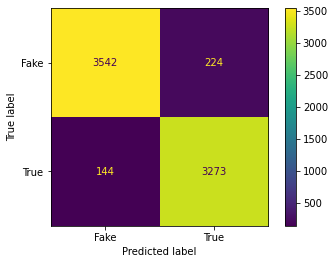

ROC_AUC_SCORE  0.986034146222435
F1_SCORE 0.946774660109922
ACCURACY SCORE 0.9487679242656272



          METRICS FOR MODEL 1 TITLES



,precision,recall,f1-score,support
Fake,0.990149,0.987520,0.988833,3766.000000
True,0.986285,0.989172,0.987726,3417.000000
accuracy,0.988306,0.988306,0.988306,0.988306
macro avg,0.988217,0.988346,0.988280,7183.000000
weighted avg,0.988311,0.988306,0.988306,7183.000000


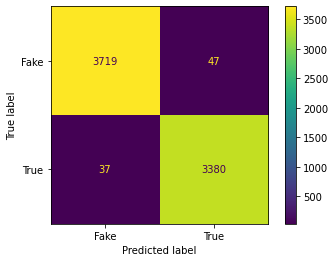

ROC_AUC_SCORE  0.9992413211192483
F1_SCORE 0.9877264757451782
ACCURACY SCORE 0.988305721843241





In [14]:
def get_model_predictions(model, test_x, probability = False):

  """ This function takes a pre-trained model in, inputs
      a test set and gets predictions from the model
  Args:    
      model - a pre-trained neural network model
      text_x: - a numpy array of string data
      probability: boolean that if set to True returns probabilities
                   instead of predictions (default = False)
  Returns: 
      predictions - an array of predictions
  """

  predictions = model.predict_on_batch(test_x).flatten()
  # getting a list of predictions into a 1d array
  predictions = tf.nn.sigmoid(predictions)
  # Apply a sigmoid since our model returns logits

  if probability != True:
    # determined whether to return probabilities or predictions
    predictions = tf.where(predictions < 0.5, 0, 1)
    # get the actual predicted values using 0.5 as a threshold

  return predictions.numpy()

  #### TEXT ########

Model_1_Probabilities_Text = get_model_predictions(Model1_Text, val_text, probability = True)
# getting probababilities from function
Model_1_Predictions_Text = get_model_predictions(Model1_Text, val_text, probability = False)
# getting predictions from function

  #### TITLE ########

Model_1_Probabilities_Title = get_model_predictions(Model1_Title, val_title, probability = True)
# getting probababilities from function
Model_1_Predictions_Title = get_model_predictions(Model1_Title, val_title, probability = False)
# getting predictions from function

def display_metrics(y_true, y_pred, y_prob, title = None):
    """ 
        Args: 
          y_true - an array of the actual labels (still needs to numpy)
          y_pred - an array of class predictions 
          y_prob - an array of class probabilities
          title = a string showing a title for the metrics (default = None)
    """

    target_names = ['Fake', 'True']
    # saving classes matching to 0 and 1
    clr = classification_report(y_true.to_numpy(),
                                y_pred,
                                labels=np.arange(2),
                                target_names=target_names,
                                output_dict=True)
    clr_df = pd.DataFrame.from_dict(clr).transpose()
    # saving as data frame and transposing to match string format

    if title != None:
      print("          METRICS FOR %s" %title)
      print("")

    display(clr_df)
    # showing data frame of classification report

    cm = confusion_matrix(y_true.to_numpy(), y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=target_names)
    disp.plot()
    plt.show()
    # showing Confusion Matrix
    print("ROC_AUC_SCORE ", roc_auc_score(y_true, y_prob))
    print("F1_SCORE", f1_score(y_true, y_pred))
    print("ACCURACY SCORE", accuracy_score(y_true, y_pred ))
    print('\n\n')
    # showing AUC, F1 Scores and Accuracy Scores
    return

display_metrics(val_label, 
                Model_1_Predictions_Text, 
                Model_1_Probabilities_Text, 
                title = "MODEL 1 TEXT")
display_metrics(val_label, 
                Model_1_Predictions_Title, 
                Model_1_Probabilities_Title, 
                title = "MODEL 1 TITLES")
# showing metrics for Model 1 text and titles

The first model has a decently high accuracy when trained with the text data and an even higher accuracy when trained with just the data in the titles.

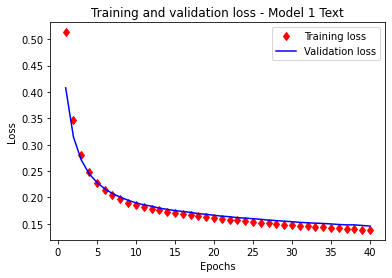

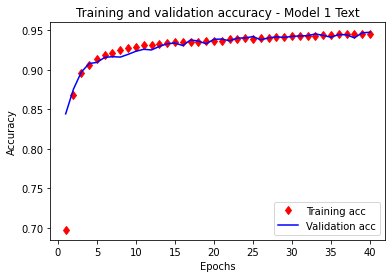

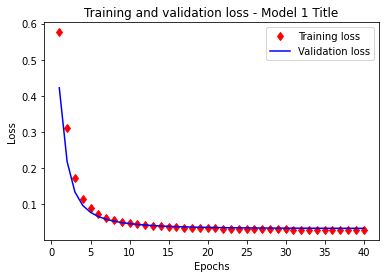

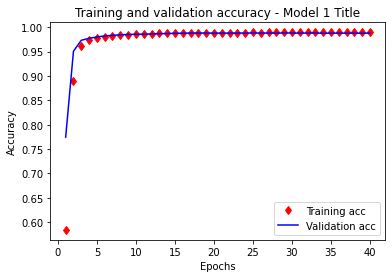

In [15]:
def train_validation_plotter(history, model_name):

  """ Simple plotting function that takes the training history
      of a neural network and make two plots; one showing
      the validation and training loss and the other showing the 
      validation and training accuracy
  """

  history_dict = history.history
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']
  # saving the history data for plotting
  epochs = range(1, len(acc) + 1)
  # add 1 since history starts from 0

  plt.plot(epochs, loss, 'rd', label='Training loss')
  # shows red diamonds for the training 
  plt.plot(epochs, val_loss, 'blue', label='Validation loss')
  plt.title('Training and validation loss - %s' %model_name)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  # First plot showing Training and Validation Loss

  plt.plot(epochs, acc, 'rd', label='Training acc')
  # shows red diamonds for the training 
  plt.plot(epochs, val_acc, 'blue', label='Validation acc')
  plt.title('Training and validation accuracy - %s' %model_name)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()
  # Second plot showing Training and Validation accuracy

train_validation_plotter(Model1_History_Text, "Model 1 Text")
# getting plots for Model 1 Text
train_validation_plotter(Model1_History_Title, "Model 1 Title")
# getting plots for Model 1 Text

In [16]:
################## EXPERIMENT 1 - MODEL 1 TEXT #######################

experiment_df = pd.DataFrame({"Experiment #":["Experiment %s" %(1)],
                                      "Data Set":["Val Text"], 
                                      "Model":["MODEL 1 (7B - nnlm-en-dim50)"],
                                      "Accuracy":[accuracy_score(val_label, 
                                                                 Model_1_Predictions_Text )],
                                      "F1 Score":[f1_score(val_label, 
                                                           Model_1_Predictions_Text)],
                                      "ROC-AUC Score":[roc_auc_score(val_label, 
                                                                     Model_1_Probabilities_Text)]})
# Initializing a dataframe for the experiments and adding

################## EXPERIMENT 2 - MODEL 1 TITLE #######################

experiment_df.loc[len(experiment_df.index)] = \
["Experiment %s" %(2), "Val Title", "MODEL 1 (7B - nnlm-en-dim50)" ,
 accuracy_score(val_label, Model_1_Predictions_Title ), 
 f1_score(val_label, Model_1_Predictions_Title ), 
 roc_auc_score(val_label, Model_1_Probabilities_Title)      ] 
# Adding the new values from this experiment into the experiment_df dataframe

display(experiment_df)

,Experiment #,Data Set,Model,Accuracy,F1 Score,ROC-AUC Score
0,Experiment 1,Val Text,MODEL 1 (7B - nnlm-en-dim50),0.948768,0.946775,0.986034
1,Experiment 2,Val Title,MODEL 1 (7B - nnlm-en-dim50),0.988306,0.987726,0.999241


Now to look at a few other pre-processed model types and add them into the
dataframe. The next one will be a similar model to 7B, but with 128 dimensions instead of 50, and with additional text normalization to remove punctuation. 

In [17]:
##############################################################################
############  EXPERIMENTS 3 & 4 - MODEL 2 ####################################
############################################################################## 
"""
NOTES ABOUT MODEL 2

Details

Based on NNLM with three hidden layers.

Input

The module takes a batch of sentences in a 1-D tensor of strings as input.

Preprocessing

The module preprocesses its input by removing punctuation and splitting on spaces.

Out of vocabulary tokens

Small fraction of the least frequent tokens and embeddings (~2.5%) are 
replaced by hash buckets. Each hash bucket is initialized using the remaining 
embedding vectors that hash to the same bucket.

Sentence embeddings

Word embeddings are combined into sentence embedding using the sqrtn
combiner (see tf.nn.embedding_lookup_sparse).

References

[1] Yoshua Bengio, Réjean Ducharme, Pascal Vincent, Christian Jauvin. 
A Neural Probabilistic Language Model. Journal of Machine Learning Research, 
3:1137-1155, 2003.

"""

url_128 = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'

#### TEXT ########

Model2_History_Text, Model2_Text = neural_net_trainer(train_text, train_label, val_text, val_label, url_128)
# fitting article text to English Google News 7B model and saving as Model2 

#### TITLE ########

Model2_History_Title, Model2_Title = neural_net_trainer(train_title, train_label, val_title, val_label, url_128)
# fitting article titles to English Google News 7B model and saving as Model2 




Epoch 1/40
57/57 [==============================] - 3s 45ms/step - loss: 0.5733 - accuracy: 0.6007 - val_loss: 0.4147 - val_accuracy: 0.8205
Epoch 2/40
57/57 [==============================] - 2s 43ms/step - loss: 0.3299 - accuracy: 0.8791 - val_loss: 0.2767 - val_accuracy: 0.9007
Epoch 3/40
57/57 [==============================] - 2s 43ms/step - loss: 0.2422 - accuracy: 0.9168 - val_loss: 0.2215 - val_accuracy: 0.9149
Epoch 4/40
57/57 [==============================] - 2s 43ms/step - loss: 0.2017 - accuracy: 0.9300 - val_loss: 0.1879 - val_accuracy: 0.9330
Epoch 5/40
57/57 [==============================] - 2s 43ms/step - loss: 0.1789 - accuracy: 0.9384 - val_loss: 0.1686 - val_accuracy: 0.9445
Epoch 6/40
57/57 [==============================] - 2s 42ms/step - loss: 0.1651 - accuracy: 0.9430 - val_loss: 0.1568 - val_accuracy: 0.9453
Epoch 7/40
57/57 [==============================] - 2s 43ms/step - loss: 0.1559 - accuracy: 0.9459 - val_loss: 0.1483 - val_accuracy: 0.9479
Epoch 8/40
57

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_4 (Dense)             (None, 16)                2064      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 124,644,769
Trainable params: 2,081
Non-trainable params: 124,642,688
_________________________________________________________________
225/225 [==============================] - 1s 5ms/step - loss: 0.1089 - accuracy: 0.9561
[0.10885639488697052, 0.9561464786529541]


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_

,precision,recall,f1-score,support
Fake,0.956029,0.964153,0.960074,3766.000000
True,0.960118,0.951127,0.955601,3417.000000
accuracy,0.957956,0.957956,0.957956,0.957956
macro avg,0.958074,0.957640,0.957838,7183.000000
weighted avg,0.957975,0.957956,0.957946,7183.000000


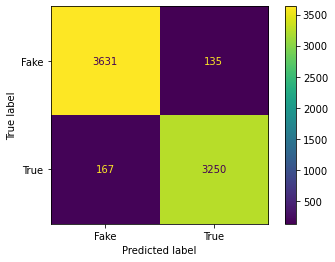

ROC_AUC_SCORE  0.9925064627193606
F1_SCORE 0.9556012937371361
ACCURACY SCORE 0.9579562856745093



          METRICS FOR MODEL 2 TITLES



,precision,recall,f1-score,support
Fake,0.998137,0.996017,0.997076,3766.000000
True,0.995620,0.997951,0.996785,3417.000000
accuracy,0.996937,0.996937,0.996937,0.996937
macro avg,0.996879,0.996984,0.996930,7183.000000
weighted avg,0.996940,0.996937,0.996937,7183.000000


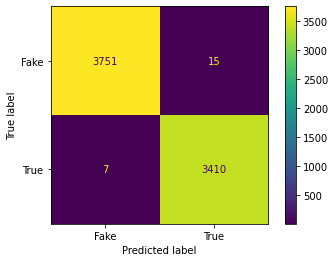

ROC_AUC_SCORE  0.9999308384508995
F1_SCORE 0.9967845659163986
ACCURACY SCORE 0.996937212863706





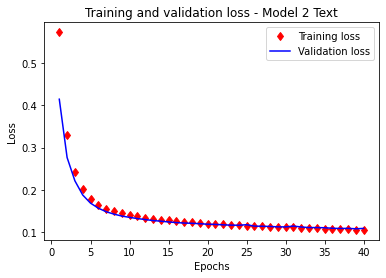

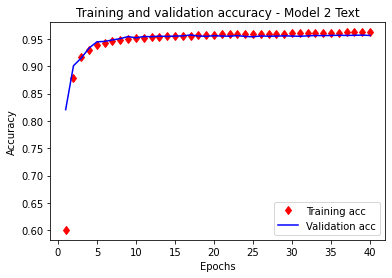

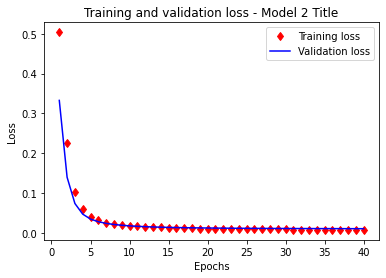

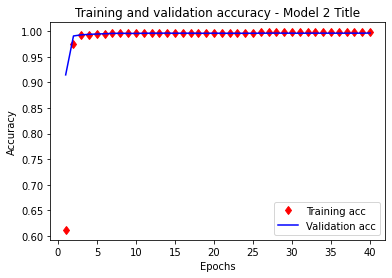

,Experiment #,Data Set,Model,Accuracy,F1 Score,ROC-AUC Score
0,Experiment 1,Val Text,MODEL 1 (7B - nnlm-en-dim50),0.948768,0.946775,0.986034
1,Experiment 2,Val Title,MODEL 1 (7B - nnlm-en-dim50),0.988306,0.987726,0.999241
2,Experiment 3,Val Text,MODEL 2 (nnlm-en-dim128-with-normalization/2),0.957956,0.955601,0.992506
3,Experiment 4,Val Title,MODEL 2 (nnlm-en-dim128-with-normalization/2),0.996937,0.996785,0.999931


In [18]:
##############################################################################
############  EXPERIMENTS 3 & 4 - MODEL 2 ####################################
############################################################################## 

#### TEXT ########

Model2_Text.summary()
# looking at summary for Model1_History_Text
Model_2_Text_Results = Model2_Text.evaluate(val_text, val_label)
print(Model_2_Text_Results)
# looking at the accuracy for the test set using text
print('\n')

#### TITLE ########

Model2_Title.summary()
# looking at summary for Model1_History_Text
Model_2_Title_Results = Model2_Title.evaluate(val_title, val_label)
print(Model_2_Title_Results)
# looking at the accuracy for the test set using titles
  
#### TEXT ########

Model_2_Probabilities_Text = get_model_predictions(Model2_Text, val_text, probability = True)
# getting probababilities from function
Model_2_Predictions_Text = get_model_predictions(Model2_Text, val_text, probability = False)
# getting predictions from function

  #### TITLE ########

Model_2_Probabilities_Title = get_model_predictions(Model2_Title, val_title, probability = True)
# getting probababilities from function
Model_2_Predictions_Title = get_model_predictions(Model2_Title, val_title, probability = False)
# getting predictions from function

display_metrics(val_label, 
                Model_2_Predictions_Text, 
                Model_2_Probabilities_Text, 
                title = "MODEL 2 TEXT")
display_metrics(val_label, 
                Model_2_Predictions_Title, 
                Model_2_Probabilities_Title, 
                title = "MODEL 2 TITLES")
# showing metrics for Model 1 text and titles

train_validation_plotter(Model2_History_Text, "Model 2 Text")
# getting plots for Model 1 Text
train_validation_plotter(Model2_History_Title, "Model 2 Title")
# getting plots for Model 1 Text

################## EXPERIMENT 3 - MODEL 2 TEXT #######################

experiment_df.loc[len(experiment_df.index)] = \
["Experiment %s" %(3), "Val Text", "MODEL 2 (nnlm-en-dim128-with-normalization/2)" ,
 accuracy_score(val_label, Model_2_Predictions_Text ), 
 f1_score(val_label, Model_2_Predictions_Text ), 
 roc_auc_score(val_label, Model_2_Probabilities_Text)      ] 
# Adding the new values from this experiment into the experiment_df dataframe

################## EXPERIMENT 4 - MODEL 2 TITLE #######################

experiment_df.loc[len(experiment_df.index)] = \
["Experiment %s" %(4), "Val Title", "MODEL 2 (nnlm-en-dim128-with-normalization/2)" ,
 accuracy_score(val_label, Model_2_Predictions_Title ), 
 f1_score(val_label, Model_2_Predictions_Title ), 
 roc_auc_score(val_label, Model_2_Probabilities_Title)      ] 
# Adding the new values from this experiment into the experiment_df dataframe

display(experiment_df)

The third experiment will be using one more version of the English Google News 200B corpus with 128 dimensions, but without normalization.

In [19]:
##############################################################################
############  EXPERIMENTS 5 & 6 - MODEL 3 ####################################
############################################################################## 
"""
NOTES ABOUT MODEL 3

Details

Based on NNLM with three hidden layers.

Input

The module takes a batch of sentences in a 1-D tensor of strings as input.

Preprocessing

The module preprocesses its input by splitting on spaces.

Out of vocabulary tokens

Small fraction of the least frequent tokens and embeddings (~2.5%)
 are replaced by hash buckets. Each hash bucket is initialized using
  the remaining embedding vectors that hash to the same bucket.

Sentence embeddings

Word embeddings are combined into sentence embedding using
 the sqrtn combiner (see tf.nn.embedding_lookup_sparse).

"""

url_200B = "https://tfhub.dev/google/nnlm-en-dim128/2"

#### TEXT ########

Model3_History_Text, Model3_Text = neural_net_trainer(train_text, train_label, val_text, val_label, url_200B)
# fitting article text to English Google News 7B model and saving as Model2 

#### TITLE ########

Model3_History_Title, Model3_Title = neural_net_trainer(train_title, train_label, val_title, val_label, url_200B)
# fitting article titles to English Google News 7B model and saving as Model2 

Epoch 1/40
57/57 [==============================] - 2s 35ms/step - loss: 0.5573 - accuracy: 0.6459 - val_loss: 0.4120 - val_accuracy: 0.8162
Epoch 2/40
57/57 [==============================] - 2s 32ms/step - loss: 0.3314 - accuracy: 0.8740 - val_loss: 0.2749 - val_accuracy: 0.8964
Epoch 3/40
57/57 [==============================] - 2s 33ms/step - loss: 0.2375 - accuracy: 0.9167 - val_loss: 0.2150 - val_accuracy: 0.9216
Epoch 4/40
57/57 [==============================] - 2s 32ms/step - loss: 0.1944 - accuracy: 0.9340 - val_loss: 0.1837 - val_accuracy: 0.9365
Epoch 5/40
57/57 [==============================] - 2s 33ms/step - loss: 0.1704 - accuracy: 0.9422 - val_loss: 0.1658 - val_accuracy: 0.9396
Epoch 6/40
57/57 [==============================] - 2s 32ms/step - loss: 0.1545 - accuracy: 0.9470 - val_loss: 0.1516 - val_accuracy: 0.9479
Epoch 7/40
57/57 [==============================] - 2s 33ms/step - loss: 0.1435 - accuracy: 0.9501 - val_loss: 0.1425 - val_accuracy: 0.9506
Epoch 8/40
57

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_8 (Dense)             (None, 16)                2064      
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 124,644,769
Trainable params: 2,081
Non-trainable params: 124,642,688
_________________________________________________________________
225/225 [==============================] - 1s 5ms/step - loss: 0.0953 - accuracy: 0.9649
[0.09530822932720184, 0.9649171829223633]


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_

          METRICS FOR MODEL 3 TEXT



,precision,recall,f1-score,support
Fake,0.973649,0.961498,0.967535,3766.00000
True,0.958141,0.971320,0.964685,3417.00000
accuracy,0.966170,0.966170,0.966170,0.96617
macro avg,0.965895,0.966409,0.966110,7183.00000
weighted avg,0.966272,0.966170,0.966179,7183.00000


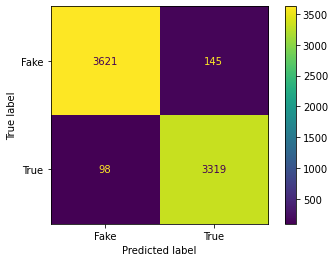

ROC_AUC_SCORE  0.9938760168107635
F1_SCORE 0.9646853654992008
ACCURACY SCORE 0.9661701239036614



          METRICS FOR MODEL 3 TITLES



,precision,recall,f1-score,support
Fake,0.994678,0.992565,0.993620,3766.000000
True,0.991825,0.994147,0.992985,3417.000000
accuracy,0.993318,0.993318,0.993318,0.993318
macro avg,0.993251,0.993356,0.993302,7183.000000
weighted avg,0.993321,0.993318,0.993318,7183.000000


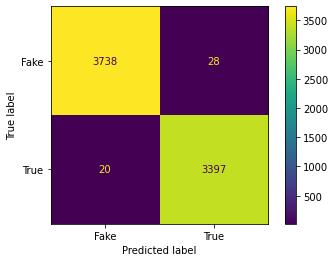

ROC_AUC_SCORE  0.9996827893894061
F1_SCORE 0.9929845074539609
ACCURACY SCORE 0.9933175553389948





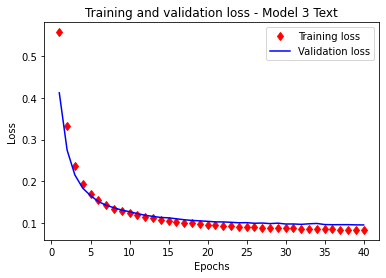

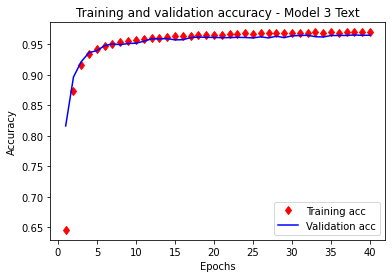

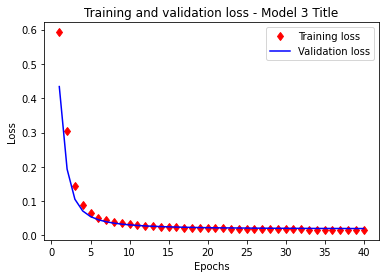

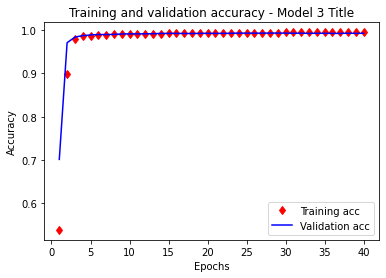

,Experiment #,Data Set,Model,Accuracy,F1 Score,ROC-AUC Score
0,Experiment 1,Val Text,MODEL 1 (7B - nnlm-en-dim50),0.948768,0.946775,0.986034
1,Experiment 2,Val Title,MODEL 1 (7B - nnlm-en-dim50),0.988306,0.987726,0.999241
2,Experiment 3,Val Text,MODEL 2 (nnlm-en-dim128-with-normalization/2),0.957956,0.955601,0.992506
3,Experiment 4,Val Title,MODEL 2 (nnlm-en-dim128-with-normalization/2),0.996937,0.996785,0.999931
4,Experiment 5,Val Text,MODEL 3 (nnlm-en-dim128),0.966170,0.964685,0.993876
5,Experiment 6,Val Title,MODEL 3 (nnlm-en-dim128),0.993318,0.992985,0.999683


In [20]:
##############################################################################
############  EXPERIMENTS 5 & 6 - MODEL 3 ####################################
##############################################################################

#### TEXT ########

Model3_Text.summary()
# looking at summary for Model1_History_Text
Model_3_Text_Results = Model3_Text.evaluate(val_text, val_label)
print(Model_3_Text_Results)
# looking at the accuracy for the test set using text
print('\n')

#### TITLE ########

Model3_Title.summary()
# looking at summary for Model1_History_Text
Model_3_Title_Results = Model3_Title.evaluate(val_title, val_label)
print(Model_3_Title_Results)
# looking at the accuracy for the test set using titles
  
#### TEXT ########

Model_3_Probabilities_Text = get_model_predictions(Model3_Text, val_text, probability = True)
# getting probababilities from function
Model_3_Predictions_Text = get_model_predictions(Model3_Text, val_text, probability = False)
# getting predictions from function

  #### TITLE ########

Model_3_Probabilities_Title = get_model_predictions(Model3_Title, val_title, probability = True)
# getting probababilities from function
Model_3_Predictions_Title = get_model_predictions(Model3_Title, val_title, probability = False)
# getting predictions from function

display_metrics(val_label, 
                Model_3_Predictions_Text, 
                Model_3_Probabilities_Text, 
                title = "MODEL 3 TEXT")
display_metrics(val_label, 
                Model_3_Predictions_Title, 
                Model_3_Probabilities_Title, 
                title = "MODEL 3 TITLES")
# showing metrics for Model 1 text and titles

train_validation_plotter(Model3_History_Text, "Model 3 Text")
# getting plots for Model 1 Text
train_validation_plotter(Model3_History_Title, "Model 3 Title")
# getting plots for Model 1 Text

################## EXPERIMENT 3 - MODEL 2 TEXT #######################

experiment_df.loc[len(experiment_df.index)] = \
["Experiment %s" %(5), "Val Text", "MODEL 3 (nnlm-en-dim128)" ,
 accuracy_score(val_label, Model_3_Predictions_Text ), 
 f1_score(val_label, Model_3_Predictions_Text ), 
 roc_auc_score(val_label, Model_3_Probabilities_Text)      ] 
# Adding the new values from this experiment into the experiment_df dataframe

################## EXPERIMENT 4 - MODEL 2 TITLE #######################

experiment_df.loc[len(experiment_df.index)] = \
["Experiment %s" %(6), "Val Title", "MODEL 3 (nnlm-en-dim128)" ,
 accuracy_score(val_label, Model_3_Predictions_Title ), 
 f1_score(val_label, Model_3_Predictions_Title ), 
 roc_auc_score(val_label, Model_3_Probabilities_Title)      ] 
# Adding the new values from this experiment into the experiment_df dataframe

display(experiment_df)

From these experiments, it appears as if **Model 3** has the highest scoring on the validation set using the **Text** data, and **Model 2** has the highest scoring using the **Title** data. It is quite tempting to only use the data from the **Title** due to the extremely high accuracies in all three models, but we will try to see if weighting the probabilities from both the **Text** using **Model 3** and the **Title** using **Model 2** can increase it even further. 

In [21]:
def probability_weighter(text_probs, title_probs, text_weight, title_weight):

  """ This function returns a single array of weighted probabilities
      generated by weighing the probabilities of both the title and the text
      probabilities
  Args:
        text_probs: an array of probabilities from the text data
        title_probs: an array of probabilities from the title data
        text_weight: A float between 0 and 1 that is equal to 1 - title_weight
        title_weight: A float between 0 and 1 that is equal to 1 - text_weight
  Returns:
        weighted_probs: an array of probabilities generated from weighted
        combinations of text and title probabilities

  """
  shape = text_probs.shape
  weighted_probs = np.empty(shape, dtype=float)
  # initializing 1d numpy array to store weighted probabilities in

  for i in range(len(text_probs)):
    weighted_probs[i] = (text_probs[i]*text_weight 
                         + title_probs[i]*title_weight) 
                          # getting weighted probabilities
  return weighted_probs


In [22]:
def get_weighted_scores(text_probs, title_probs, y_true, fine_tune = -1):

  """
  Args:
        text_probs: an array of probabilities from the text data
        title_probs: an array of probabilities from the title data
        y_true: an array of the actual labels
        fine_tune: a negative integer that tells what power of 10 to raise 
        the divisions to (default = -1 for only 10 divisions)
  Returns:
        weight_scores: a dataframe showing the scores for each weighing
  """
  scores = []
  # initialize a list

  for i in range(10):
    text_wt = i*(10**fine_tune)
    title_wt = 1 - text_wt
    # initializing text and title weights
    wt_probs = probability_weighter(text_probs, 
                                    title_probs, 
                                    text_wt, 
                                    title_wt )
    # get the weighted probabilties
    wt_predicts = tf.where(wt_probs < 0.5, 0, 1)
    # get the actual predicted values using 0.5 as a threshold
    auc = roc_auc_score(y_true, wt_probs)
    f1 = f1_score(y_true, wt_predicts)
    acc= accuracy_score(y_true, wt_predicts )
    # getting metrics
    scores.append((text_wt, title_wt, auc, f1, acc ))
    # add weights and scores into the list

  scores = pd.DataFrame(scores, columns = ['Text Weight', 
                                           'Title Weight', 
                                           'ROC-AUC Score', 
                                           'F1 Score', 
                                           'Accuracy Score'])
                                  # turn the list into a dataframe
  return scores
    
weight_scores = get_weighted_scores(Model_3_Probabilities_Text, 
                                    Model_2_Probabilities_Title, 
                                    val_label)
# getting weighted scores
display(weight_scores)

,Text Weight,Title Weight,ROC-AUC Score,F1 Score,Accuracy Score
0,0.0,1.0,0.999931,0.996785,0.996937
1,0.1,0.9,0.999962,0.996638,0.996798
2,0.2,0.8,0.999964,0.996929,0.997076
3,0.3,0.7,0.999961,0.997368,0.997494
4,0.4,0.6,0.999957,0.997659,0.997773
5,0.5,0.5,0.999928,0.996631,0.996798
6,0.6,0.4,0.999644,0.985262,0.985939
7,0.7,0.3,0.999156,0.980329,0.981206
8,0.8,0.2,0.998443,0.974531,0.975637
9,0.9,0.1,0.997295,0.969300,0.970625


In [23]:
Best_Weights_Row = weight_scores['Accuracy Score'].idxmax()
print(weight_scores.iloc[Best_Weights_Row])

Text Weight       0.400000
Title Weight      0.600000
ROC-AUC Score     0.999957
F1 Score          0.997659
Accuracy Score    0.997773
Name: 4, dtype: float64


We can see that when using a weight of probabilities between the **text** and the **title** we increase our accuracy even further. Let's see if we can get a more precise amount for the weightings

In [24]:
weight_scores2 = get_weighted_scores(Model_3_Probabilities_Text, 
                                    Model_2_Probabilities_Title, 
                                    val_label, fine_tune = -2)
Best_Weights_Row2 = weight_scores2['Accuracy Score'].idxmax()
print(weight_scores2.iloc[Best_Weights_Row2])

Text Weight       0.000000
Title Weight      1.000000
ROC-AUC Score     0.999931
F1 Score          0.996785
Accuracy Score    0.996937
Name: 0, dtype: float64


The scores are not increasing by making the divisions more fine, so we will stick with the results from the first run and save the weights for both the **Text** and **Title**. Now to put everything together and look at the test scores.

,precision,recall,f1-score,support
Fake,0.998514,0.996822,0.997668,4720.00000
True,0.996485,0.998357,0.997420,4260.00000
accuracy,0.997550,0.997550,0.997550,0.99755
macro avg,0.997500,0.997589,0.997544,8980.00000
weighted avg,0.997552,0.997550,0.997550,8980.00000


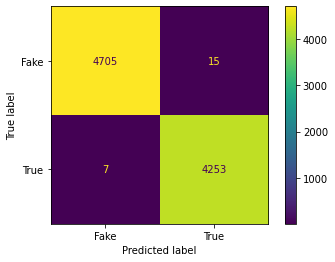

ROC_AUC_SCORE  0.9999097338266889
F1_SCORE 0.9974202626641652
ACCURACY SCORE 0.9975501113585746





In [28]:
Best_Weight_Text = weight_scores.iloc[Best_Weights_Row][0]
Best_Weight_Title = weight_scores.iloc[Best_Weights_Row][1]
Best_Model_Txt = Model3_Text
Best_Model_Title = Model2_Title
# saving models and weights 

def Model_tester(test_text, test_title, y_true):

    """ this function takes in two numpy arrays, puts them
        into the models chosen above with their weights
        and returns the AUC Score, F1 Score and 
        Accuracy Scores

    Args:
        test_text: a numpy array containing strings showing
                    article content 
        test_title: a numpy array containing strings showing
                    article title
        test_labels: a numpy array showing the actual label
                      corresponding to the test_text and 
                      test_title
    """

    probabilities_text = get_model_predictions(Best_Model_Txt, 
                                               test_text, 
                                               probability = True)
    # getting text probababilities from function

    probabilities_title = get_model_predictions(Best_Model_Title, 
                                                 test_title, 
                                                 probability = True)
    # getting title probababilities from function

    wt_probs = probability_weighter(probabilities_text, 
                                        probabilities_title, 
                                        Best_Weight_Text, 
                                        Best_Weight_Title )
    # get the weighted probabilties

    wt_predicts = tf.where(wt_probs < 0.5, 0, 1)
    # get the actual predicted values using 0.5 as a threshold

    auc_test = roc_auc_score(test_label, wt_probs)
    f1_test = f1_score(test_label, wt_predicts)
    acc_test = accuracy_score(test_label, wt_predicts )
    # saving metrics
    display_metrics(y_true, wt_predicts, wt_probs )
    # print results

Model_tester(test_text, test_title, test_label)
# entering the unseen test data into the function 

Our test scores are extremely high for our stacked model, and they are quite similar to our validation set, so the model performs well on unseen data as well.

In [31]:
Best_Model_Txt.save("cnn_model_txt.h5")
Best_Model_Title.save("cnn_model_ttle.h5")
# saving models for later use
# /Users/edwardmiller/Desktop/School documents/DATA MINING FOLDER/Data Mining Project Folder

In [26]:
###################################################################################
###################################################################################